# Handwritten Text Recognition Pipeline (OCR)
The pipeline consists of the following stages:
Preprocessing: Converting images to grayscale, applying Gaussian Blur, and Adaptive Thresholding to clean the background.
Segmentation: Using regionprops to isolate individual characters from the noise-reduced image.
Alignment (Center of Mass): Aligning extracted characters based on their ink density center, which significantly improves CNN accuracy (similar to the MNIST dataset preparation).
Prediction: Using a pre-trained Convolutional Neural Network (CNN) trained on the EMNIST dataset.

In [7]:
#pip install opencv-python-headless matplotlib scikit-image tensorflow scipy

# 1. Imports and Configuration
Here we define the input/output directories and the mapping dictionary for the EMNIST dataset (mapping class IDs to actual characters).
# 2. Helper Functions
We define two critical functions here:

show_image: Displays images inline using Matplotlib.

prepare_segment_with_com: Resizes the segmented character and positions it based on its Center of Mass (CoM). This step is crucial for high accuracy with neural networks.

In [ ]:
import cv2
import numpy as np
import os
import glob
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from tensorflow.keras.models import load_model
from scipy.ndimage import center_of_mass
import math

# --- Configuration ---
# Notebooks often run in a specific directory. 
# Ensure these folders exist or point to the right place.
INPUT_FOLDER_NAME = "../handwritten-receipts" 
OUTPUT_BASE_DIR = "../all-segmented-outputs"
NN_TARGET_SIZE = 28
MODEL_PATH = '../models/emnist_model.h5'

# Control whether to show intermediate images inline
DEBUG_MODE = True 

# EMNIST Mapping
emnist_labels = {
    0: '0', 1: '1', 2: '2', 3: '3', 4: '4', 5: '5', 6: '6', 7: '7', 8: '8', 9: '9',
    10: 'A', 11: 'B', 12: 'C', 13: 'D', 14: 'E', 15: 'F', 16: 'G', 17: 'H', 18: 'I', 19: 'J',
    20: 'K', 21: 'L', 22: 'M', 23: 'N', 24: 'O', 25: 'P', 26: 'Q', 27: 'R', 28: 'S', 29: 'T',
    30: 'U', 31: 'V', 32: 'W', 33: 'X', 34: 'Y', 35: 'Z',
    36: 'a', 37: 'b', 38: 'd', 39: 'e', 40: 'f', 41: 'g', 42: 'h', 43: 'n', 44: 'q', 45: 'r', 46: 't'
}

# --- Helper Functions ---

def show_image(title, img):
    """
    Helper function: Displays an image using matplotlib inline.
    """
    if not DEBUG_MODE:
        return

    # Create a white bar for the text
    text_img = np.zeros((30, img.shape[1], 3), dtype=np.uint8) + 255
    cv2.putText(text_img, title, (10, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
    
    if img.ndim == 2:
        display_img = cv2.cvtColor(img, cv2.COLOR_GRAY2BGR)
    else:
        display_img = img
        
    if text_img.shape[1] != display_img.shape[1]:
        scale = text_img.shape[1] / display_img.shape[1]
        new_h = int(display_img.shape[0] * scale)
        display_img = cv2.resize(display_img, (text_img.shape[1], new_h))
        
    combined_img = np.vstack((text_img, display_img))
    
    plt.figure(figsize=(6, 6)) # Adjusted size for Notebook readability
    plt.imshow(cv2.cvtColor(combined_img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show() 

def prepare_segment_with_com(segment, target_size=NN_TARGET_SIZE):
    """
    Centers the character based on its Center of Mass (CoM).
    """
    h, w = segment.shape
    if h <= 0 or w <= 0: return None

    inner_size = 20
    scale = inner_size / max(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    
    if new_h <= 0 or new_w <= 0: return None
        
    resized = cv2.resize(segment, (new_w, new_h), interpolation=cv2.INTER_AREA)
    canvas = np.zeros((target_size, target_size), dtype=np.uint8)

    cy, cx = center_of_mass(resized)
    
    if math.isnan(cy) or math.isnan(cx):
        cy, cx = new_h / 2, new_w / 2 

    shift_y = (target_size / 2) - cy
    shift_x = (target_size / 2) - cx

    for r in range(new_h):
        for c in range(new_w):
            target_r = int(r + shift_y)
            target_c = int(c + shift_x)
            
            if 0 <= target_r < target_size and 0 <= target_c < target_size:
                canvas[target_r, target_c] = resized[r, c]
    
    return canvas

print("Libraries imported and functions defined.")

Libraries imported and functions defined.


# 3. Load Model
Loads the pre-trained emnist_model.h5 file. Ensure this file is uploaded to the notebook's working directory.

In [9]:
print(f"Loading Model from {MODEL_PATH}...")
try:
    model = load_model(MODEL_PATH)
    print("Model loaded successfully.")
except Exception as e:
    print(f"Error loading model: {e}")
    print("Ensure 'emnist_model.h5' is in the same directory or upload it.")
    model = None

Loading Model from ../models/emnist_model.h5...
Model loaded successfully.


# 4. Main Processing Loop
This is the main execution block. It iterates through all images in the input folder and applies the following steps:
    1. Grayscale & Blur: Reduces noise.
    2. Adaptive Thresholding: Converts the image to binary (black/white).
    3. Morphological Opening: Removes small noise artifacts.
    4. Segmentation: Identifies character regions.
    5. Prediction: Classifies each character using the CNN model.

Processing 10 images...

--- PROCESSING: Amoxicillin1000mg.jpg ---


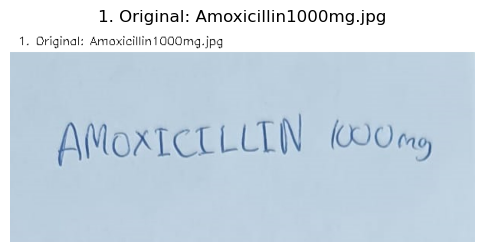

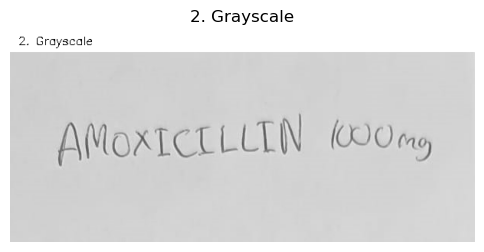

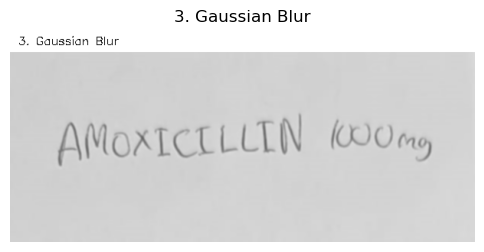

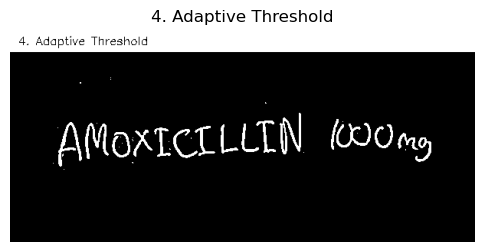

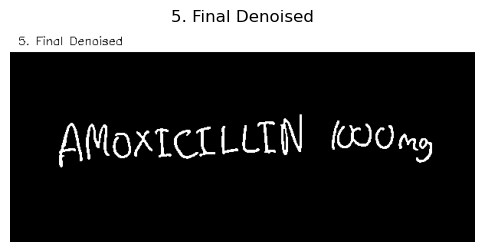

  Found 16 potential regions.


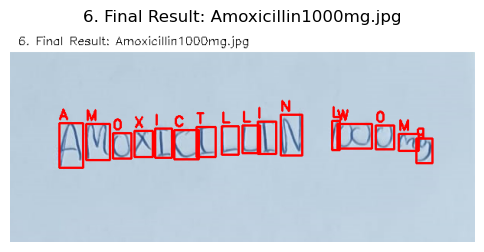


--- PROCESSING: Cipro500mg.jpg ---


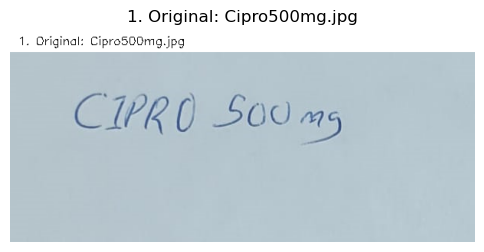

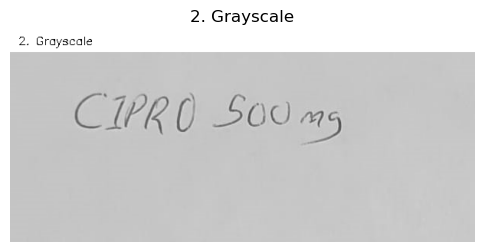

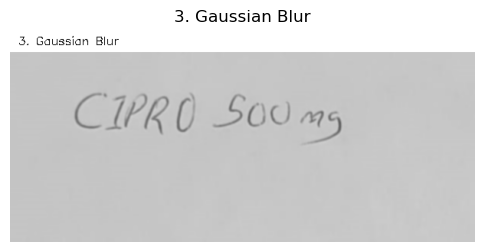

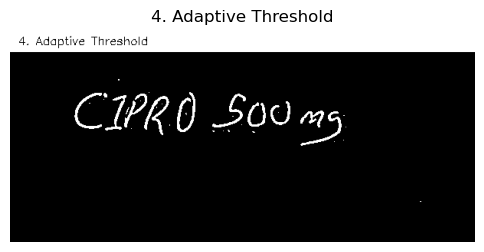

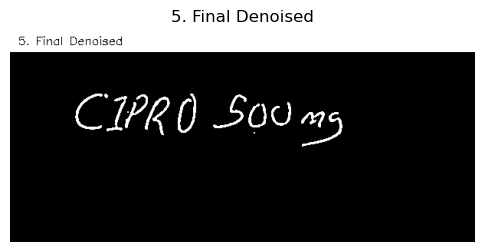

  Found 13 potential regions.


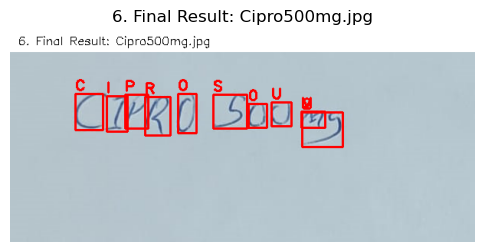


--- PROCESSING: coaxil125mg.jpg ---


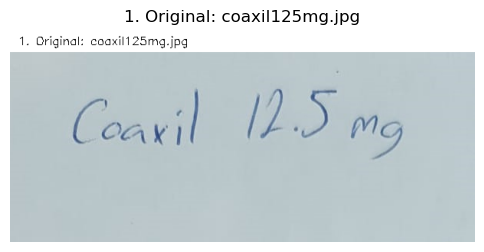

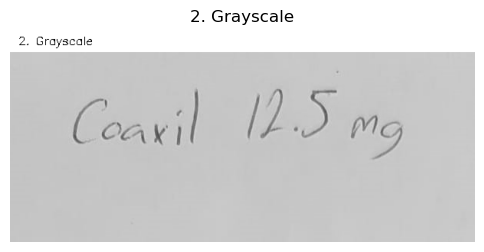

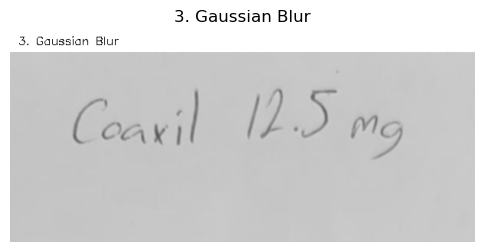

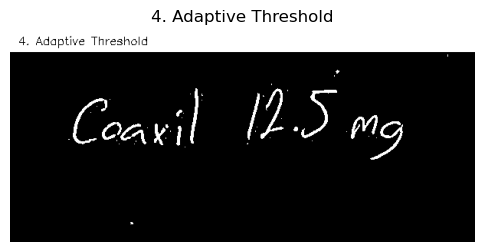

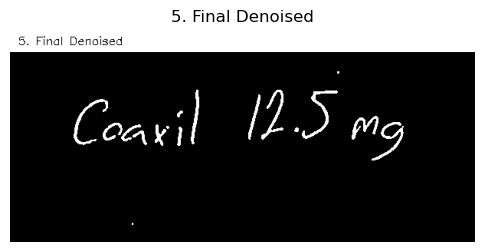

  Found 17 potential regions.


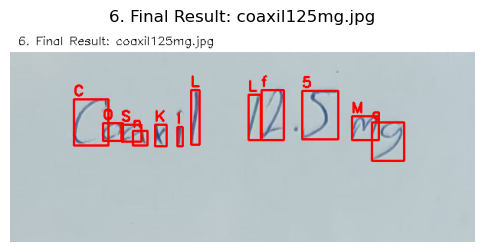


--- PROCESSING: depakine500mg.jpg ---


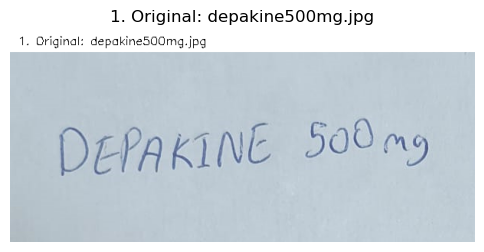

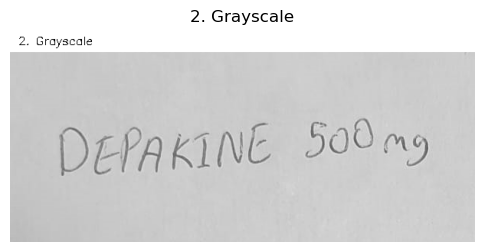

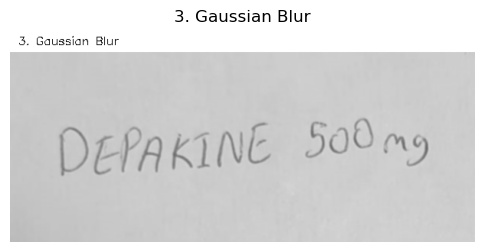

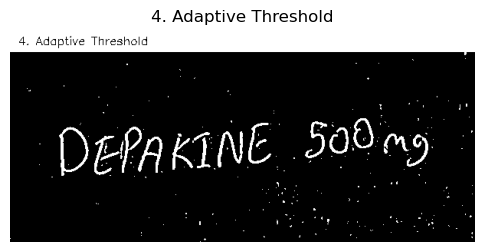

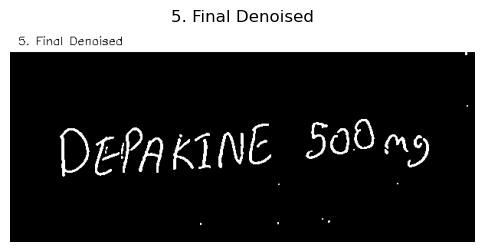

  Found 32 potential regions.


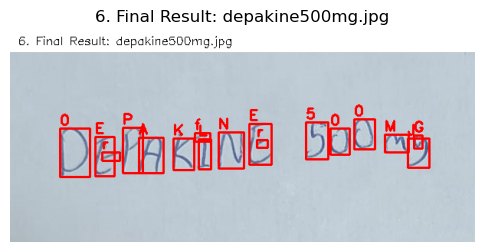


--- PROCESSING: insulin100iu.jpg ---


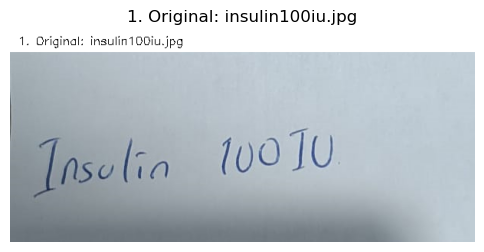

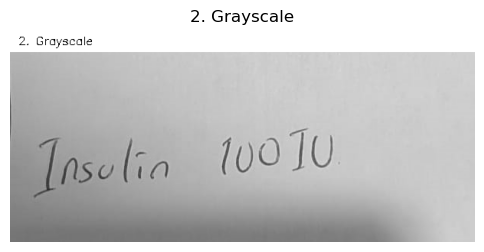

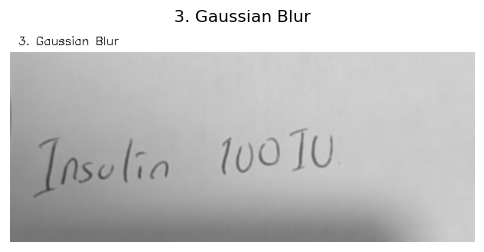

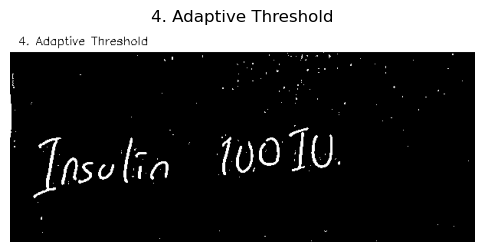

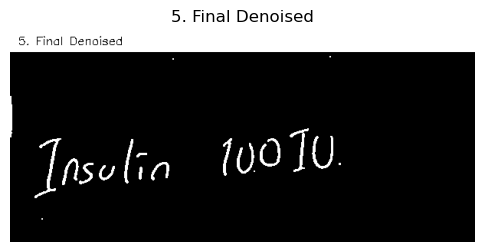

  Found 19 potential regions.


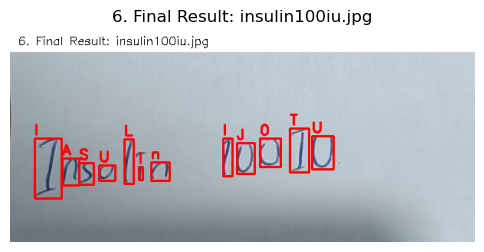


--- PROCESSING: lantus100ml.jpg ---


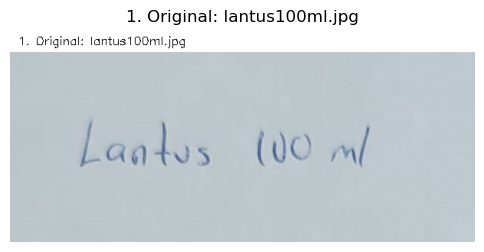

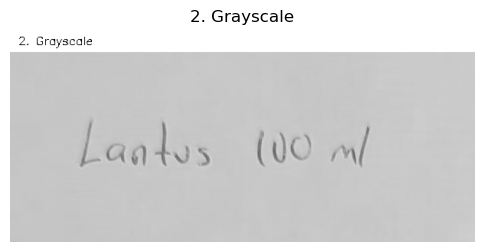

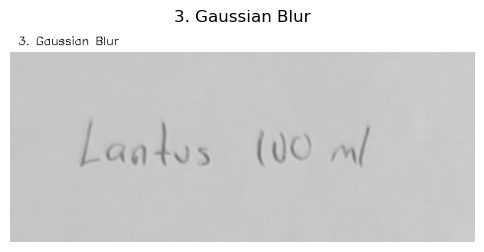

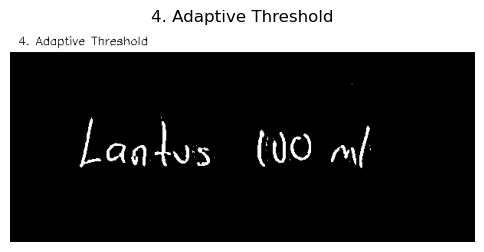

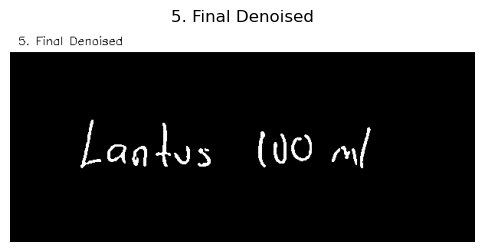

  Found 14 potential regions.


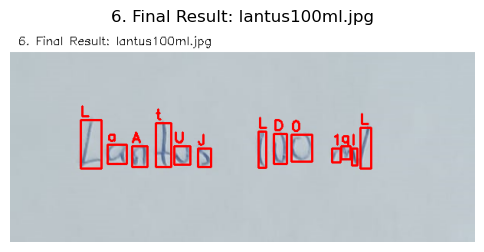


--- PROCESSING: levozin5mg.jpg ---


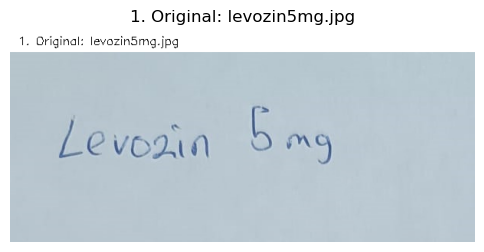

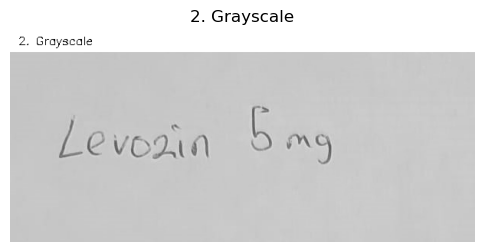

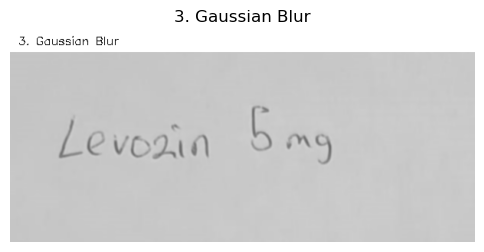

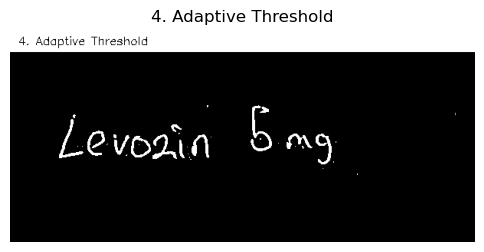

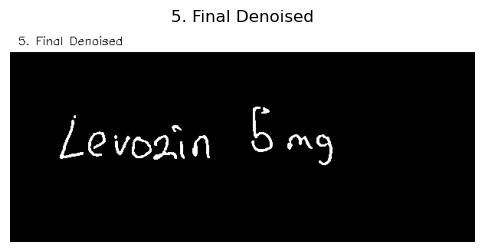

  Found 14 potential regions.


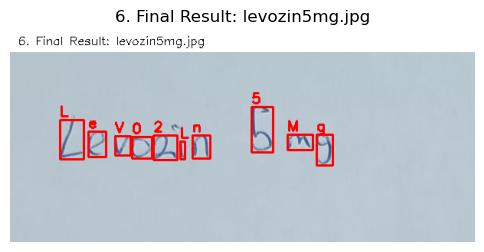


--- PROCESSING: norvasc5mg.jpg ---


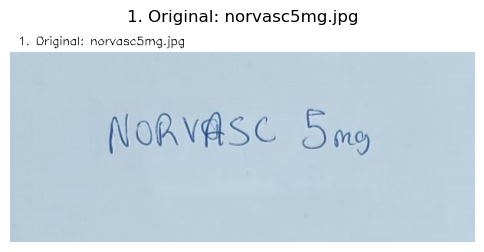

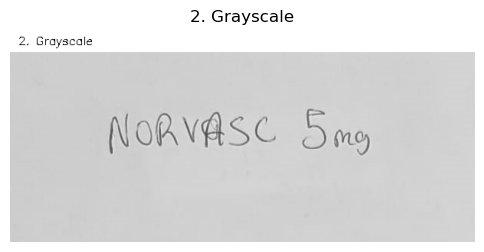

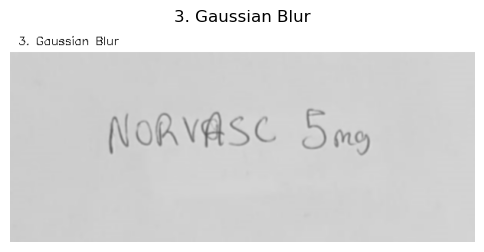

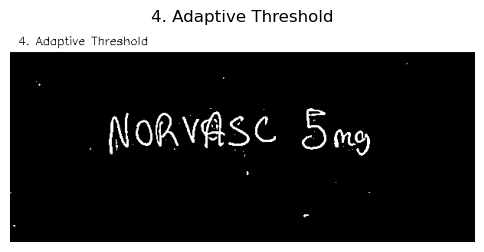

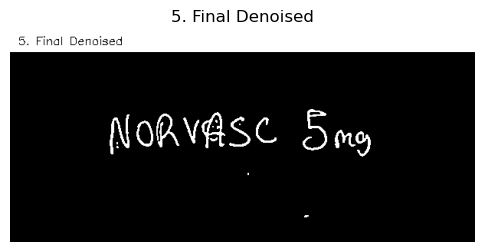

  Found 18 potential regions.


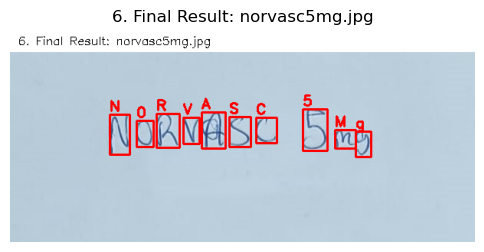


--- PROCESSING: tramadol50mg.jpg ---


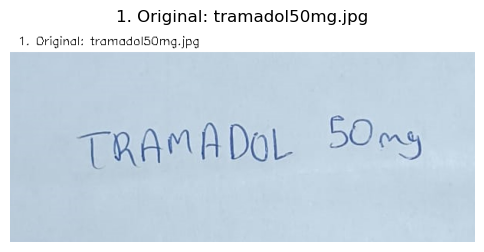

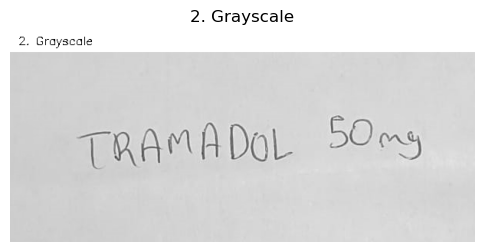

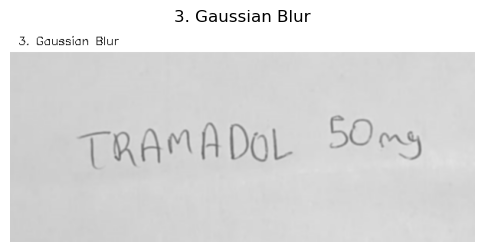

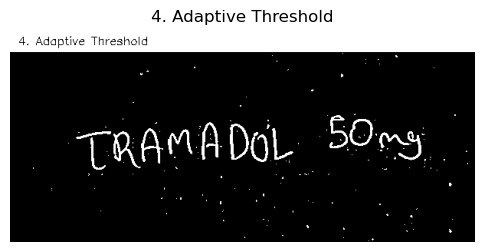

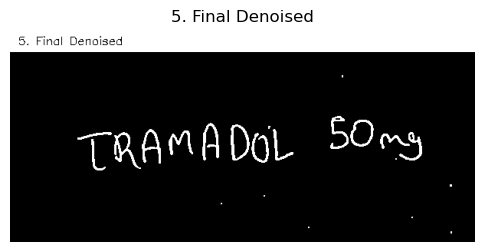

  Found 22 potential regions.


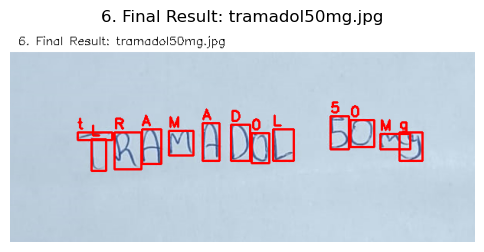


--- PROCESSING: xarelto15mg.jpg ---


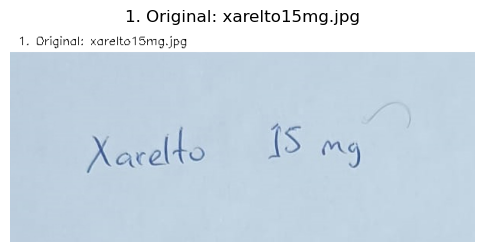

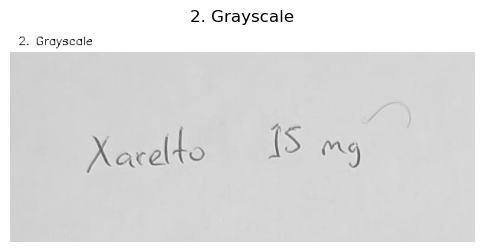

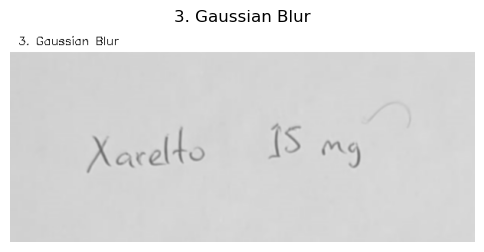

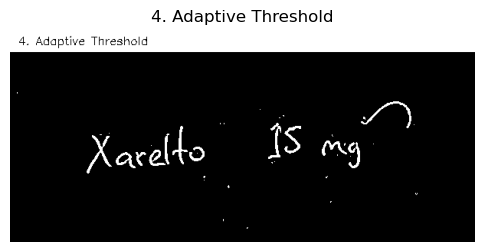

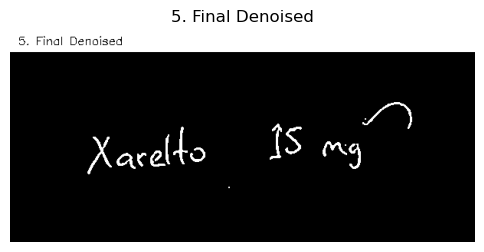

  Found 15 potential regions.


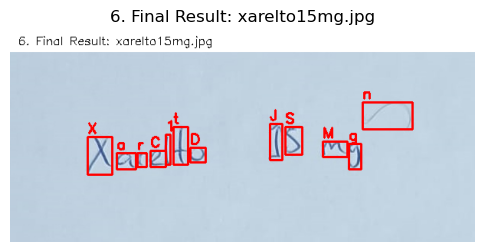


Done.


In [13]:
if not os.path.exists(INPUT_FOLDER_NAME):
    # If folder doesn't exist, create it so user knows where to put images
    os.makedirs(INPUT_FOLDER_NAME)
    print(f"Created folder '{INPUT_FOLDER_NAME}'. Please upload images there.")
else:
    image_paths = glob.glob(os.path.join(INPUT_FOLDER_NAME, '*.*'))
    valid_images = [p for p in image_paths if p.lower().endswith(('.png', '.jpg', '.jpeg'))]

    if not valid_images:
         print(f"No images found in '{INPUT_FOLDER_NAME}'. Please upload some receipts.")
    else:
        print(f"Processing {len(valid_images)} images...")

    for file_path in valid_images:
        file_name = os.path.basename(file_path)
        base_name = os.path.splitext(file_name)[0]
        print(f"\n--- PROCESSING: {file_name} ---")
        
        img = cv2.imread(file_path)
        if img is None: continue
        
        original_img = img.copy()
        
        # 1. Original
        show_image(f"1. Original: {file_name}", original_img)
        
        # --- PREPROCESSING ---
        # 2. Grayscale
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        show_image("2. Grayscale", gray)
        
        # 3. Blur
        blurred = cv2.GaussianBlur(gray, (9, 9), 1.0)
        show_image("3. Gaussian Blur", blurred)
        
        # 4. Threshold
        binary_thresh = cv2.adaptiveThreshold(
            blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
            cv2.THRESH_BINARY_INV, 11, 2
        )
        show_image("4. Adaptive Threshold", binary_thresh)
        
        # 5. Denoise
        median_cleaned = cv2.medianBlur(binary_thresh, 3)
        kernel = np.ones((2, 2), np.uint8)
        denoised = cv2.morphologyEx(median_cleaned, cv2.MORPH_OPEN, kernel)
        show_image("5. Final Denoised", denoised)
        
        # --- SEGMENTATION ---
        output_dir = os.path.join(OUTPUT_BASE_DIR, f"segmented_{base_name}")
        if not os.path.exists(output_dir): os.makedirs(output_dir)

        labeled_image = label(denoised)
        regions = regionprops(labeled_image)
        
        boxed_img = original_img.copy()
        
        # Sort L -> R
        sorted_regions = sorted(regions, key=lambda r: r.bbox[1])
        
        print(f"  Found {len(sorted_regions)} potential regions.")

        seg_count = 0
        for i, region in enumerate(sorted_regions):
            minr, minc, maxr, maxc = region.bbox
            h, w = maxr - minr, maxc - minc
            
            if h < 10 or w < 5: continue
            
            # Masking
            rough_crop = denoised[minr:maxr, minc:maxc]
            mask = region.image
            
            character_segment = np.zeros_like(rough_crop)
            character_segment[mask] = rough_crop[mask]
            
            # Preparation (CoM)
            nn_input = prepare_segment_with_com(character_segment)
            
            if nn_input is not None:
                # Save
                cv2.imwrite(os.path.join(output_dir, f"char_{seg_count:03d}.png"), nn_input)
                
                # Draw Box
                cv2.rectangle(boxed_img, (minc, minr), (maxc, maxr), (0, 0, 255), 2)
                
                # Predict
                if model:
                    inp = nn_input.astype('float32') / 255.0
                    inp = np.expand_dims(inp, axis=-1)
                    inp = np.expand_dims(inp, axis=0)
                    
                    pred = model.predict(inp, verbose=0)
                    cid = np.argmax(pred)
                    conf = np.max(pred)
                    char = emnist_labels.get(cid, '?')
                    
                    cv2.putText(boxed_img, f"{char}", (minc, minr-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,0,255), 2)
                    # print(f"  Seg {seg_count}: {char} ({conf*100:.1f}%)") # Optional print
                
                seg_count += 1
        
        # 6. Final Result
        show_image(f"6. Final Result: {file_name}", boxed_img)

print("\nDone.")